In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from enum import IntEnum

# prefix = "AMZN_2012-06-21_34200000_57600000"
prefix = "INTC_2012-06-21_34200000_57600000"

trades_data_file = f"./data/{prefix}_message_5.csv"
orderbook_data_file = f"./data/{prefix}_orderbook_5.csv"

trade_df = pd.read_csv(trades_data_file, names=(
    'time',
    'type',
    'orderId',
    'size',
    'price',
    'direction',
),
    skiprows=1
)

orderbook_df = pd.read_csv(orderbook_data_file, names=(
    'ask1_price',
    'ask1_size',
    'bid1_price',
    'bid1_size',

    'ask2_price',
    'ask2_size',
    'bid2_price',
    'bid2_size',

    'ask3_price',
    'ask3_size',
    'bid3_price',
    'bid3_size',

    'ask4_price',
    'ask4_size',
    'bid4_price',
    'bid4_size',

    'ask5_price',
    'ask5_size',
    'bid5_price',
    'bid5_size',
))

df = pd.concat([trade_df, orderbook_df], axis=1)
df['event_lapse'] = df['time'].diff().fillna(0)

class OrderbookEventTypes(IntEnum):
    Limit=1
    PartialCancel=2
    Deletion=3
    ExecutionOfVisibleOrder=4
    ExecutionOfHiddenOrder=5
    TradingHalt=7

class OrderbookIndexes(IntEnum):
    Bid=0
    Ask=1

class OrderbookTypes(IntEnum):
    Limit=0
    Market=1
    Cancel=2

# Remove hidden orderbook events
df = df[
    (df['type'] != OrderbookEventTypes.ExecutionOfHiddenOrder) & 
    (df['type'] != OrderbookEventTypes.TradingHalt) &
    (df['time'])
    ]

DEPTH = 3
ORDER_TYPES = 3
PRICE_TICK = 100
HALF_PRICE_TICK = PRICE_TICK / 2
NORMALIZED_QUEUE_MAX = 100

In [35]:
midprice = (df['bid1_price'] + df["ask1_price"]) / 2
spread = df["ask1_price"] - df['bid1_price']

conditions = [
    spread == PRICE_TICK,
    df["ask1_price"] >= df['bid1_price'],
    df["ask1_price"] < df['bid1_price']
]

choices = [
    midprice,
    midprice + PRICE_TICK,
    midprice - PRICE_TICK
]

df['reference_price'] = np.select(conditions, choices)

for n in range(0, DEPTH):
    price_depth = (PRICE_TICK * n) + HALF_PRICE_TICK

    bid_price_level = df['reference_price'] - price_depth
    ask_price_level = df['reference_price'] + price_depth

    bid_conditions = [
        bid_price_level == df['bid1_price'],
        bid_price_level == df['bid2_price'],
        bid_price_level == df['bid3_price'],
        bid_price_level == df['bid4_price'],
        bid_price_level == df['bid5_price'],
    ]
    ask_conditions = [
        ask_price_level == df['ask1_price'],
        ask_price_level == df['ask2_price'],
        ask_price_level == df['ask3_price'],
        ask_price_level == df['ask4_price'],
        ask_price_level == df['ask5_price'],
    ]

    bid_choices = [
        df['bid1_size'],
        df['bid2_size'],
        df['bid3_size'],
        df['bid4_size'],
        df['bid5_size']
    ]
    ask_choices = [
        df['ask1_size'],
        df['ask2_size'],
        df['ask3_size'],
        df['ask4_size'],
        df['ask5_size']
    ]

    df[f'norm_bid{n + 1}_price'] = bid_price_level
    df[f'norm_bid{n + 1}_size'] = np.select(bid_conditions, bid_choices)
    
    df[f'norm_ask{n + 1}_price'] = ask_price_level
    df[f'norm_ask{n + 1}_size'] = np.select(ask_conditions, ask_choices)

# print(df['ask1_price'], df['bid1_price'], df['reference_price'])
# print(df)

In [36]:
def getOrdersFromData(dataframe, depth, isBid):
    correctDirection = 1 if isBid else -1
    limitOrder = (dataframe['type'] == 1)
    cancelOrder = (dataframe['type'] == 2) | (dataframe['type'] == 3)
    marketOrderCondititons = (
        (dataframe['type'] == 4) &
        (dataframe[f'norm_bid{depth}_size'] > 0) &
        (dataframe['direction'] == correctDirection)
    )

    return (dataframe[limitOrder], dataframe[cancelOrder], dataframe[marketOrderCondititons])

<BarContainer object of 6 artists>

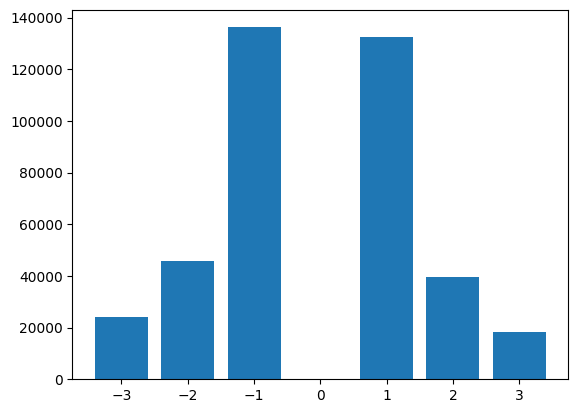

In [37]:
event_in_bid = [
    (df['norm_bid1_price'] == df['price']),
    (df['norm_bid2_price'] == df['price']),
    (df['norm_bid3_price'] == df['price']),
]
event_in_ask = [
    (df['norm_ask1_price'] == df['price']),
    (df['norm_ask2_price'] == df['price']),
    (df['norm_ask3_price'] == df['price']),
]

data = np.zeros(6)
buckets = [-3, -2, -1, 1, 2, 3]
MIDPOINT = 2

for price_level in range(0, DEPTH):
    bids_at_depth = df.loc[event_in_bid[price_level]]
    asks_at_depth = df.loc[event_in_ask[price_level]]

    data[MIDPOINT - price_level] = len(bids_at_depth)
    data[MIDPOINT + price_level + 1] = len(asks_at_depth)

plt.bar(buckets, data)

In [38]:
lambdas = np.zeros((DEPTH, 2, ORDER_TYPES, NORMALIZED_QUEUE_MAX))

pd.options.mode.chained_assignment = None  # default='warn'

for price_level in range(0, DEPTH):
    orders_at_depth = df.loc[(event_in_bid[price_level]) | (event_in_ask[price_level])]
    orders_at_depth['dt_order'] = orders_at_depth['time'].diff().fillna(0)
    
    bids_at_depth = orders_at_depth.loc[event_in_bid[price_level]]
    asks_at_depth = orders_at_depth.loc[event_in_ask[price_level]]

    average_event_size = (bids_at_depth['size'].mean() + asks_at_depth['size'].mean()) / 2

    bids_at_depth.loc[:, 'queue_length'] = np.ceil(bids_at_depth[f'norm_bid{price_level + 1}_size'].astype(float) / bids_at_depth['size'].mean())
    asks_at_depth.loc[:, 'queue_length'] = np.ceil(asks_at_depth[f'norm_ask{price_level + 1}_size'].astype(float) / asks_at_depth['size'].mean())

    print(f'Price Level {price_level + 1} | AES {average_event_size}')

    for queue_index in range(0, NORMALIZED_QUEUE_MAX):
        bid_queue = bids_at_depth.loc[bids_at_depth['queue_length'] == queue_index]
        ask_queue = asks_at_depth.loc[asks_at_depth['queue_length'] == queue_index]

        bidLimitOrder, bidCancelOrder, bidMarketOrderCondititons  = getOrdersFromData(bid_queue, price_level + 1, True)
        askLimitOrder, askCancelOrder, askMarketOrderCondititons = getOrdersFromData(ask_queue, price_level + 1, False)
        
        numberOfOrdersAtBidQueue = len(bid_queue)
        numberOfOrdersAtAskQueue = len(ask_queue)

        dt_order = orders_at_depth['dt_order'].mean()

        bidLimitIntensity = (len(bidLimitOrder)) / (numberOfOrdersAtBidQueue * dt_order)
        askLimitIntensity = (len(askLimitOrder)) / (numberOfOrdersAtAskQueue * dt_order)

        lambdas[price_level, OrderbookIndexes.Bid, OrderbookTypes.Limit, queue_index] = bidLimitIntensity
        lambdas[price_level, OrderbookIndexes.Bid, OrderbookTypes.Market, queue_index] = len(bidMarketOrderCondititons) / (numberOfOrdersAtBidQueue * dt_order)
        lambdas[price_level, OrderbookIndexes.Bid, OrderbookTypes.Cancel, queue_index] = len(bidCancelOrder) / (numberOfOrdersAtBidQueue * dt_order)

        lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Limit, queue_index] = askLimitIntensity
        lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Market, queue_index] = len(askMarketOrderCondititons) / (numberOfOrdersAtAskQueue * dt_order)
        lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Cancel, queue_index] = len(askCancelOrder) / (numberOfOrdersAtAskQueue * dt_order)
        
    #     if(price_level == 0 and queue_index in [0, 5, 20]):
    #     # if(price_level == 0 and queue_index in [0]):
    #         print(f'[+] Printing information for queue={queue_index}')
        
    #         display(pd.concat([bid_queue, ask_queue]).sort_values(['time']))

    #         print(f"Num of orders | BQ {numberOfOrdersAtBidQueue} | AQ {numberOfOrdersAtAskQueue}")
    #         print(f"Avg. Order delta_t | {dt_order}")        
    # print()

Price Level 1 | AES 421.9902965794754


C:\Users\trevo\AppData\Local\Temp\ipykernel_5432\98897792.py:32: RuntimeWarning: invalid value encountered in scalar divide
  askLimitIntensity = (len(askLimitOrder)) / (numberOfOrdersAtAskQueue * dt_order)
C:\Users\trevo\AppData\Local\Temp\ipykernel_5432\98897792.py:39: RuntimeWarning: invalid value encountered in scalar divide
  lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Market, queue_index] = len(askMarketOrderCondititons) / (numberOfOrdersAtAskQueue * dt_order)
C:\Users\trevo\AppData\Local\Temp\ipykernel_5432\98897792.py:40: RuntimeWarning: invalid value encountered in scalar divide
  lambdas[price_level, OrderbookIndexes.Ask, OrderbookTypes.Cancel, queue_index] = len(askCancelOrder) / (numberOfOrdersAtAskQueue * dt_order)


Price Level 2 | AES 450.865610649392
Price Level 3 | AES 452.31053288069677


C:\Users\trevo\AppData\Local\Temp\ipykernel_5432\98897792.py:31: RuntimeWarning: invalid value encountered in scalar divide
  bidLimitIntensity = (len(bidLimitOrder)) / (numberOfOrdersAtBidQueue * dt_order)
C:\Users\trevo\AppData\Local\Temp\ipykernel_5432\98897792.py:35: RuntimeWarning: invalid value encountered in scalar divide
  lambdas[price_level, OrderbookIndexes.Bid, OrderbookTypes.Market, queue_index] = len(bidMarketOrderCondititons) / (numberOfOrdersAtBidQueue * dt_order)
C:\Users\trevo\AppData\Local\Temp\ipykernel_5432\98897792.py:36: RuntimeWarning: invalid value encountered in scalar divide
  lambdas[price_level, OrderbookIndexes.Bid, OrderbookTypes.Cancel, queue_index] = len(bidCancelOrder) / (numberOfOrdersAtBidQueue * dt_order)
C:\Users\trevo\AppData\Local\Temp\ipykernel_5432\98897792.py:32: RuntimeWarning: invalid value encountered in scalar divide
  askLimitIntensity = (len(askLimitOrder)) / (numberOfOrdersAtAskQueue * dt_order)
C:\Users\trevo\AppData\Local\Temp\ipykern

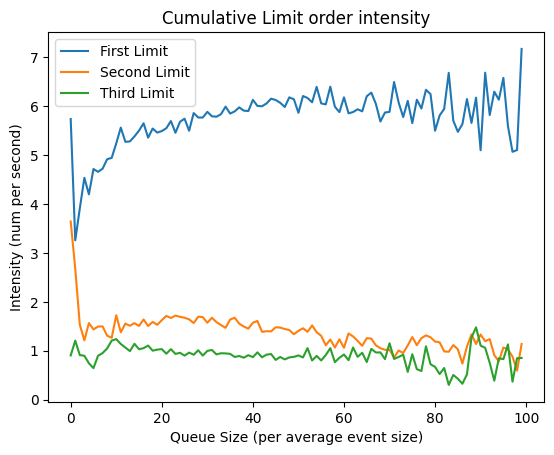

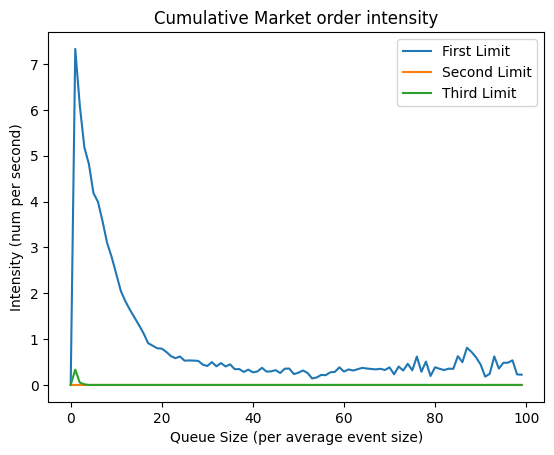

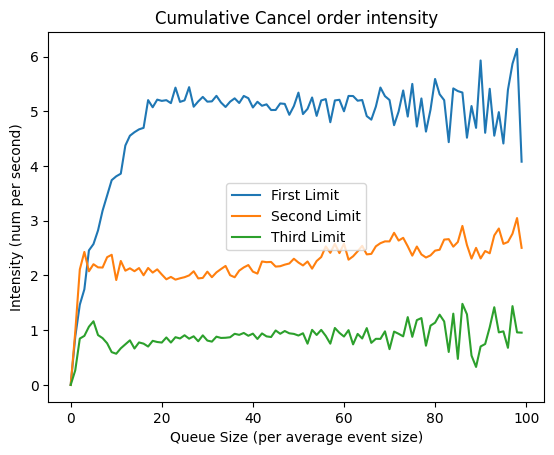

In [39]:
for order_type in OrderbookTypes:
    for x in range(0, 2):
        lambdas[0][x][order_type][np.isnan(lambdas[0][x][order_type])] = 0
        lambdas[1][x][order_type][np.isnan(lambdas[1][x][order_type])] = 0
        lambdas[2][x][order_type][np.isnan(lambdas[2][x][order_type])] = 0

    plt.plot((lambdas[0][OrderbookIndexes.Bid][order_type] + lambdas[0][OrderbookIndexes.Ask][order_type]) / 2, label=f"First Limit")
    plt.plot((lambdas[1][OrderbookIndexes.Bid][order_type] + lambdas[1][OrderbookIndexes.Ask][order_type]) / 2, label=f"Second Limit")
    plt.plot((lambdas[2][OrderbookIndexes.Bid][order_type] +  lambdas[2][OrderbookIndexes.Ask][order_type]) / 2, label=f"Third Limit")
    # plt.plot(lambdas[0][OrderbookIndexes.Bid][order_type], label=f"Bid First Limit")
    # plt.plot(lambdas[1][OrderbookIndexes.Bid][order_type], label=f"Bid Second Limit")
    # plt.plot(lambdas[2][OrderbookIndexes.Bid][order_type], label=f"Bid Third Limit")
    
    # plt.plot(lambdas[0][OrderbookIndexes.Ask][order_type], label=f"Ask First Limit")
    # plt.plot(lambdas[1][OrderbookIndexes.Ask][order_type], label=f"Ask Second Limit")
    # plt.plot(lambdas[2][OrderbookIndexes.Ask][order_type], label=f"Ask Third Limit")

    if (order_type == OrderbookTypes.Limit):
        order_name = "Limit"
    elif (order_type == OrderbookTypes.Market):
        order_name = "Market"
    elif (order_type == OrderbookTypes.Cancel):
        order_name = "Cancel"

    plt.ylabel("Intensity (num per second)")
    plt.xlabel("Queue Size (per average event size)")
    plt.legend()
    plt.title(f"Cumulative {order_name} order intensity")
    plt.show()

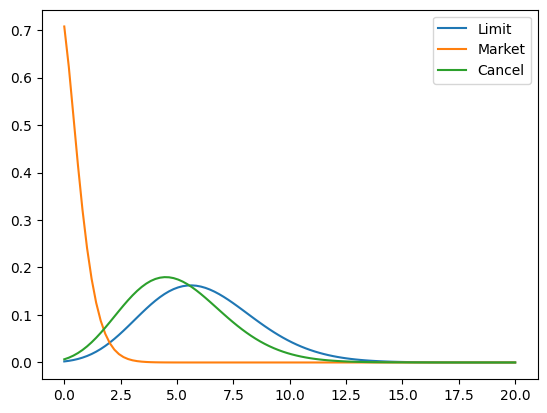

In [49]:
import math
# Poission Distribution
def getPoissonValue(intensity, x):
    return math.pow(intensity, x) * \
        math.pow(math.e, -intensity) / \
        math.gamma(x + 1)

depth = 0
queue_length = 40

# for depth_level in range(0, DEPTH):

intensityLimit = lambdas[depth][OrderbookIndexes.Bid][OrderbookTypes.Limit][queue_length]
intensityMarket = lambdas[depth][OrderbookIndexes.Bid][OrderbookTypes.Market][queue_length]
intensityCancel = lambdas[depth][OrderbookIndexes.Bid][OrderbookTypes.Cancel][queue_length]

x_vals = np.linspace(0, 20, 100)
limit_vals = []
market_vals = []
cancel_vals = []

for x in x_vals:
    limit = getPoissonValue(intensityLimit, x)
    market = getPoissonValue(intensityMarket, x)
    cancel = getPoissonValue(intensityCancel, x)
    limit_vals.append(limit)
    market_vals.append(market)
    cancel_vals.append(cancel)

plt.plot(x_vals, limit_vals, label="Limit")
plt.plot(x_vals, market_vals, label="Market")
plt.plot(x_vals, cancel_vals, label="Cancel")
plt.legend()
plt.show()

In [43]:
# Monte Carlo Simulation
import importlib
import simulate

importlib.reload(simulate.simulate)

from simulate.simulate import Simulation

prob_of_exec = Simulation(lambdas, length=500)
prob_of_exec.run()

for orderbook in prob_of_exec.orderbook_history:
    print(orderbook)

[[], []]
[[[100.01, 13.402299039411282]], [[99.99, 2.6479668614266823]]]
[[[100.01, 8.448063303949565]], [[99.99, 1.3559220816288147]]]
[[[100.01, 5.348719289050775]], [[99.99, 5.643716011327654]]]
[[[100.01, 6.365666281581952]], [[99.99, 6.290015102126843]]]
[[[100.01, 9.019682520132669]], [[99.99, 8.210328731992941]]]
[[[100.01, 5.778331237893159]], [[99.99, 2.8820923170861947]]]
[[[100.01, 8.276779099156485]], [[99.99, 1.2476780501209173]]]
[[[100.01, 10.514416890200351]], [[99.99, 1.3826918539611739]]]
[[[100.01, 8.984077448244875]], [[99.99, 13.355190524769863]]]
[[[100.01, 11.226650421273732]], [[99.99, 13.75886220228189]]]
[[[100.01, 9.121123963875611]], [[99.99, 9.445701209385362]]]
[[[100.01, 4.806737977170193]], [[99.99, 10.808959606886638]]]
[[[100.01, 4.719132979242017]], [[99.99, 5.890181991950866]]]
[[[100.01, 9.733809104266014]], [[99.99, 15.00733058681581]]]
[[[100.01, 13.397497533932798]], [[99.99, 18.646822422058605]]]
[[[100.01, 10.196943134390533]], [[99.99, 9.28577

In [42]:
# # Invarient Distibutions

# def ArrivalDepartureRatio(depth, n):
#     limitBid = lambdas[depth][OrderbookIndexes.Bid][0][n]
#     cancelBid = lambdas[depth][OrderbookIndexes.Bid][1][n + 1]
#     marketBid = lambdas[depth][OrderbookIndexes.Bid][2][n + 1]

#     return (limitBid) / (cancelBid + marketBid)

# def InvariantDistribution(depth, n):
#     product = 1
    
#     for j in range(0, n):
#         ratio = ArrivalDepartureRatio(depth, j)
#         product *= (ratio if ratio != 0 else 1)
    
#     denuminator_sum = 0
#     denominator_product = 1

#     for n in range(0, NORMALIZED_QUEUE_MAX):
#         for j in range(0, n):
#             ratio = ArrivalDepartureRatio(depth, j)
#             denominator_product *= ratio

#         denuminator_sum += product
#     denominator = 1 + denuminator_sum 

#     # print(product, denominator)
#     # print()

#     return product / denominator

# for depth in range(0, DEPTH):
#     x_vals = np.linspace(0, NORMALIZED_QUEUE_MAX - 1, NORMALIZED_QUEUE_MAX)
#     y_vals = [InvariantDistribution(depth, int(x)) for x in x_vals]

#     plt.scatter(x_vals, y_vals)
#     plt.show()